In [1]:
#!pip install tensorflow-gpu

In [2]:
#!pip install tensorflow_addons

In [3]:
import random
import numpy as np
import tensorflow.keras
#import wandb
#from wandb.keras import WandbCallback
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input, Conv2D, MaxPooling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import matplotlib.pyplot as plt

from tensorflow.keras import applications

from tensorflow.keras.preprocessing import image
import os

import re

Number of Cat images -  166
subject15.happy


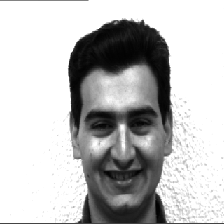

In [4]:
#http://vision.ucsd.edu/content/yale-face-database
img_dir = "../data/yalefaces/"
faceImages = os.listdir(img_dir)
print("Number of Cat images - ",str(len(faceImages)))
print(faceImages[1])

#img_path = 'elephant.jpg'
img = image.load_img(img_dir + faceImages[1], target_size=(224, 224))
x = image.img_to_array(img)

img

In [5]:
x.shape

(224, 224, 3)

In [6]:
x_train = np.zeros((len(faceImages), 224, 224, 3))
y_train = np.empty((len(faceImages),), dtype=np.object_)
for i, face in enumerate(faceImages):
    img = image.load_img(img_dir + face, target_size=(224, 224))
    x = image.img_to_array(img)
    y = face[ : face.index('.')]
    x_train[i] = x
    y_train[i] = y
    
print(x_train.shape)
print(y_train.shape)

(166, 224, 224, 3)
(166,)


In [7]:
y_train

array(['subject09', 'subject15', 'subject15', 'subject01', 'subject07',
       'subject06', 'subject01', 'subject07', 'subject01', 'subject06',
       'subject11', 'subject08', 'subject02', 'subject03', 'subject11',
       'subject15', 'subject15', 'subject15', 'subject13', 'subject03',
       'subject06', 'subject05', 'subject13', 'subject12', 'subject13',
       'subject15', 'subject08', 'subject01', 'subject01', 'subject03',
       'subject07', 'subject07', 'subject08', 'subject09', 'subject02',
       'subject05', 'subject09', 'subject04', 'subject01', 'subject10',
       'subject12', 'subject04', 'subject14', 'subject02', 'subject09',
       'subject15', 'subject06', 'subject10', 'subject10', 'subject15',
       'subject03', 'subject13', 'subject09', 'subject10', 'subject01',
       'subject13', 'subject05', 'subject10', 'subject01', 'subject14',
       'subject06', 'subject13', 'subject08', 'subject01', 'subject03',
       'subject01', 'subject14', 'subject01', 'subject02', 'subj

In [8]:
np.where(y_train == 'subject05')

(array([ 21,  35,  56,  78,  91,  96,  98, 110, 115, 132, 160]),)

In [9]:
y_train[8]

'subject01'

In [10]:
np.unique(y_train)

array(['subject01', 'subject02', 'subject03', 'subject04', 'subject05',
       'subject06', 'subject07', 'subject08', 'subject09', 'subject10',
       'subject11', 'subject12', 'subject13', 'subject14', 'subject15'],
      dtype=object)

In [11]:
random.choice([1,2,3,1,3,4,3,2,2,3,3,3])

4

In [12]:
random.randint(0, 9)

1

In [13]:
# make pairs
def make_pairs(x, y):
    classes = np.unique(y_train)
    num_classes = len(classes)
    
    face_indices_dict = {cls:np.where(y == cls)[0] for cls in classes}
    
    triplets = []
    labels = []

    for anc_idx in range(len(x)):
        anc = x[anc_idx]
        pos_label = y[anc_idx] # Person Name
        all_neg_labels = [cls for cls in classes if cls not in [pos_label]]
        for _ in range(10): # forming 10 triplets per person-face
            # Randomly choose a matching example
            pos_idx = random.choice(face_indices_dict[pos_label])
            pos = x[pos_idx]
       
            # Randomly choose a non-matching example
            neg_label = random.choice(all_neg_labels)
            neg_idx = random.choice(face_indices_dict[neg_label])
            neg = x[neg_idx]
            
            triplets += [[anc, pos, neg]]
            labels += [1]            

    return np.array(triplets), np.array(labels)

triplets_train, labels_train = make_pairs(x_train, y_train)
#pairs_test, labels_test = make_pairs(x_test, y_test)

In [14]:
x_train.shape

(166, 224, 224, 3)

In [15]:
triplets_train.shape

(1660, 3, 224, 224, 3)

In [16]:
labels_train.shape

(1660,)

In [17]:
triplets_train[0,0,:].shape

(224, 224, 3)

In [18]:
def showPic(pixels):
    image = pixels/np.amax(pixels)
    image = np.clip(image, 0, 1)
    plt.imshow(image)

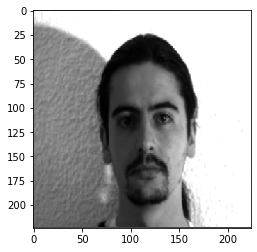

In [19]:
# take a peek at the data
showPic(triplets_train[0,0,:])

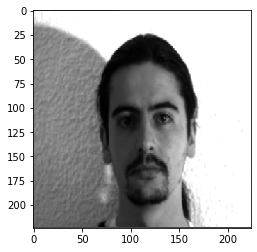

In [20]:
showPic(triplets_train[0,1,:])

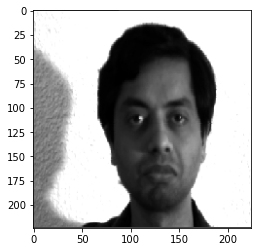

In [21]:
showPic(triplets_train[0,2,:])

In [22]:
labels_train[0]

1

In [23]:
pairs_train = triplets_train/np.max(triplets_train)

In [24]:
import tensorflow_addons as tfa
from tensorflow.keras import backend as K

In [25]:
inputs = Input(shape=(224, 224, 3), name='inputs')

conv1 = Conv2D(activation=K.relu, filters=6, padding='same', kernel_size=10, name='conv1')(inputs)
conv2 = Conv2D(activation=K.relu, filters=6, kernel_size=10, name='conv2')(conv1)
max2 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv2)

conv3 = Conv2D(activation=K.relu, filters=12, padding='same', kernel_size=10, name='conv3')(max2)
conv4 = Conv2D(activation=K.relu, filters=12, kernel_size=10, name='conv4')(conv3)
max4 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv4)

conv5 = Conv2D(activation=K.relu, filters=24, padding='same', kernel_size=10, name='conv5')(max4)
conv6 = Conv2D(activation=K.relu, filters=24, kernel_size=10, name='conv6')(conv5)
max6 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv6)

conv7 = Conv2D(activation=K.relu, filters=48, padding='same', kernel_size=10, name='conv7')(max6)
conv8 = Conv2D(activation=K.relu, filters=48, kernel_size=10, name='conv8')(conv7)
max8 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv8)

flat = Flatten()(max8)

dense1 = Dense(256, activation=K.relu)(flat)

dense2 = Dense(128, activation=K.relu)(dense1)

face_encoder_model = Model(inputs=inputs, outputs=dense2)

In [26]:
face_encoder_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 224, 224, 6)       1806      
_________________________________________________________________
conv2 (Conv2D)               (None, 215, 215, 6)       3606      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 107, 107, 6)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 107, 107, 12)      7212      
_________________________________________________________________
conv4 (Conv2D)               (None, 98, 98, 12)        14412     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 12)        0     

In [27]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon())) # sum_square come as zero 

def identity_loss(y_true, y_pred):
    return K.mean(y_pred)

def triplet_loss(x, alpha = 0.2):
    # Triplet Loss function.
    anchor,positive,negative = x
    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)
    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
    return loss

input_anchor_face = Input(shape=(224, 224, 3))
input_pos_face = Input(shape=(224, 224, 3))
input_neg_face = Input(shape=(224, 224, 3))

anchor_encoded = face_encoder_model(input_anchor_face)
pos_encoded = face_encoder_model(input_pos_face)
neg_encoded = face_encoder_model(input_neg_face)

loss = Lambda(triplet_loss)([anchor_encoded, pos_encoded, neg_encoded]) 

optimizer = RMSprop(learning_rate=0.0001)

model = Model(inputs=[input_anchor_face, input_pos_face, input_neg_face], outputs=loss)
model.compile(loss=identity_loss, optimizer=optimizer)

In [28]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 128)          799532      input_1[0][0]                    
                                                                 input_2[0][0]              

In [29]:
pairs_train[:,0].shape

(1660, 224, 224, 3)

In [30]:
pairs_train[:,1].shape

(1660, 224, 224, 3)

In [33]:
early_stopping_callback = tensorflow.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True,  monitor='loss')

model.fit([triplets_train[:,0], triplets_train[:,1], triplets_train[:,2]], labels_train[:], 
          batch_size=32, epochs=30,
         callbacks=[early_stopping_callback])

Epoch 1/30
52/52 [==============================] - 57s 1s/step - loss: 0.0074
Epoch 2/30
52/52 [==============================] - 63s 1s/step - loss: 0.0110
Epoch 3/30
52/52 [==============================] - 62s 1s/step - loss: 0.0058
Epoch 4/30
52/52 [==============================] - 62s 1s/step - loss: 0.0014
Epoch 5/30
52/52 [==============================] - 62s 1s/step - loss: 0.0048
Epoch 6/30
52/52 [==============================] - 62s 1s/step - loss: 0.0035
Epoch 7/30
52/52 [==============================] - 88s 2s/step - loss: 8.7337e-04
Epoch 8/30
52/52 [==============================] - 124s 2s/step - loss: 0.0015
Epoch 9/30
52/52 [==============================] - 77s 1s/step - loss: 0.0042
Epoch 10/30
52/52 [==============================] - 63s 1s/step - loss: 0.0041
Epoch 11/30
52/52 [==============================] - 105s 2s/step - loss: 1.8857e-04
Epoch 12/30
52/52 [==============================] - 132s 3s/step - loss: 0.0023
Epoch 13/30
52/52 [===================

In [34]:
face_encoder_model.save("./models/face_recognition_as_siamese_network_custom_100.h5")

In [35]:
face_encoder_model = tensorflow.keras.models.load_model("./models/face_recognition_as_siamese_network_custom_100.h5")

In [36]:
encoded_face = face_encoder_model.predict(pairs_train[119,1,:].reshape(1, 224, 224, 3))

In [37]:
encoded_face.shape

(1, 128)

In [38]:
encoded_face

array([[0.01868521, 0.00075073, 0.        , 0.0119945 , 0.01661981,
        0.        , 0.        , 0.        , 0.01445452, 0.        ,
        0.        , 0.00510313, 0.00448841, 0.        , 0.01493087,
        0.        , 0.        , 0.0164545 , 0.        , 0.        ,
        0.        , 0.00692148, 0.        , 0.00682257, 0.        ,
        0.01800912, 0.01058827, 0.01061556, 0.00871685, 0.00108148,
        0.0136847 , 0.        , 0.        , 0.00961361, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01321483,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00754314, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.01571633, 0.        , 0.        ,
        0.        , 0.        , 0.02894226, 0.        , 0.01086653,
        0.00370349, 0.        , 0.02503878, 0.0183742 , 0.        ,
        0.        , 0.        , 0.        , 0.01

* https://github.com/Ekeany/Siamese-Network-with-Triplet-Loss/blob/master/MachinePart1.ipynb

Kaggle - Challenges in Representation Learning: Facial Expression Recognition Challenge
  * https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/discussion
  * https://www.youtube.com/watch?v=DtBu1u5aBsc

Sliding Window Classifier: Rain Drop Detection
  * https://github.com/tobybreckon/raindrop-detection-cnn/blob/master/raindrop_detection_sliding_window.py

Convolutional implementation of the sliding window algorithm
  * https://medium.com/ai-quest/convolutional-implementation-of-the-sliding-window-algorithm-db93a49f99a0